In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, fmin_cg

%matplotlib inline

In [2]:
cols = ['user_id', 'item_id', 'rating', 'tstamp']
ml_100k = pd.read_csv('./ml-100k/u.data', names=cols, sep="\t")

In [3]:
ml_100k.head(5)

,user_id,item_id,rating,tstamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# delete timestamp column
del ml_100k['tstamp']

In [5]:
print(ml_100k.user_id.max(), ml_100k.user_id.min())
print(ml_100k.item_id.max(), ml_100k.item_id.min())
print(ml_100k.rating.max(), ml_100k.rating.min())

(943, 1)
(1682, 1)
(5, 1)


Il faut stocker les scores utilisateurs dans une matrice dont:
- les lignes correspondent aux films
- les colonnes correspondent aux utilisateurs

La manière la plus simple (compacte, diligente...) est d'utiliser la méthode groupBy avec comme argument une liste des colonne 'user_id' et 'item_id' de Pandas et de pivoter les colonnes avec unstack(). On dirait presque que cette méthode a été inventée juste pour ça! En dernier lieu on extrait les valeurs de la table pivotée et on les stocke dans une matrice (en réalité un object np.ndarray). Il restera ensuite finalement juste à remplacer les nan (les films que les utilisateurs n'ont pas notés) par 0. Ceci n'est évidemment possible que parce que la note minimale est 1 (dont je me suis assuré avant)

In [6]:
Y = (ml_100k.groupby(['item_id', 'user_id']).mean().unstack()).values

In [7]:
Y[np.isnan(Y)] = 0

In [8]:
# un aperçu du résultat, c'est conforme à la matrice que fournit Ng dans son cours
Y[:10, :10]

array([[ 5.,  4.,  0.,  0.,  4.,  4.,  0.,  0.,  0.,  4.],
       [ 3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  4.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  2.,  5.,  3.,  4.,  4.],
       [ 1.,  0.,  0.,  0.,  0.,  4.,  5.,  0.,  0.,  0.],
       [ 5.,  0.,  0.,  0.,  0.,  4.,  5.,  0.,  0.,  4.],
       [ 3.,  2.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.]])

It's possible to visualize the rating matrix Y using matplotlib, with the function plt.imshow(*matrix*)

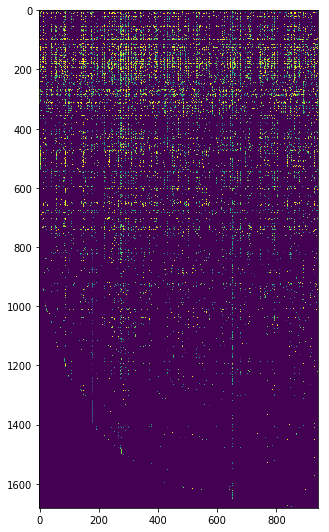

In [9]:
fig, ax = plt.subplots(figsize=(5, 10))
ax = plt.imshow(Y)
plt.show()

# Collaborative filtering cost function

Next step is to implement the collaborative filtering cost function. It is the conventional sum of squared error cost function that's useful for regression:
$$J\left(x^{(1)}, ..., x^{(n)}, \theta^{(1)}, ..., \theta^{(n)}\right)= \frac{1}{2}\sum_{(i,j):r(i,j)=1}\left(\left(\theta^{(i)}\right)^T x^{(i)}-y^{(i,j)}\right)^2+\text{Regularization}$$

The strange (double) sum index highlights the use of the special matrix $\left[R\right]$, a binary indicator matrix. It is used to remove movies that users haven't rated from the calculation of the cost function. Indeed 0 here does not mean that the user rated it terribly (\<1), but rather that the information is unavailable

Finally, the regularization terms, that are used to prevent overfitting are given the form of L2-regularization:
$$ \text{Regularization}\,=\frac{\lambda}{2}\cdot\sum_i \left(x^{(i)}\right)^{2}+\frac{\lambda}{2}\cdot\sum_j \left(\theta^{(j)}\right)^{2}$$

In [11]:
# the R indicator matrix, maybe better to use a logical mask instead...
R = np.where(Y==0, 0, 1)
R[:10, :10]

array([[1, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0]])

In [12]:
from __future__ import division

# the cofi_cost_function
def cofi_cost(params, Y, R, n_users, n_movies, n_features, regularization_param):
    """ collaborative filtering cost function. It's a standard SSQ cost function,
    with unrated items handled using a indicator function."""
    # fold parameters x and theta into matrices
    X = params[:int(n_movies * n_features)].reshape((n_movies, n_features))
    theta = params[int(n_movies * n_features):].reshape((n_users, n_features))
    # The cost function and regularization terms
    J = 0.5 * (np.sum(np.sum(R * ((X.dot(theta.transpose()) - Y) ** 2))))
    J += regularization_param / 2 * np.sum(theta ** 2)
    J += regularization_param / 2 * np.sum(X ** 2)
    # print("cost : {0}".format(J))
    return J

num_users, num_movies, num_features = 4, 5, 3
X = np.random.random((num_movies, num_features))
Theta = np.random.random((num_users, num_features))
# print X, Theta
Y_test = Y[:num_movies, :num_users]
R_test = R[:num_movies, :num_users]

params = np.concatenate((X.ravel(), Theta.ravel()), axis=0)

cofi_cost(params, Y_test, R_test, num_users, num_movies, num_features, 0.01)

27.340095866755068

In [13]:
from scipy.io import loadmat
mat_ws = loadmat("ex8_movieParams.mat")
mat_ws

{'Theta': array([[ 0.28544362, -1.68426509,  0.26293877, ...,  0.76723235,
         -1.10460164, -0.25186708],
        [ 0.50501321, -0.45464846,  0.31746244, ...,  1.09306336,
         -1.20029436, -0.39161676],
        [-0.43191656, -0.47880449,  0.84671111, ...,  1.36333976,
         -0.32523542, -0.19468212],
        ..., 
        [ 1.0586926 , -0.8087176 ,  0.56935771, ...,  0.80421422,
         -0.74346778, -0.11985885],
        [ 0.89058932, -0.12894734,  0.35560466, ...,  1.37426807,
         -0.7526549 , -0.81135311],
        [ 0.82414136, -0.38892594,  1.06940502, ...,  1.28423703,
         -0.98349993, -0.53184838]]),
 'X': array([[ 1.0486855 , -0.40023196,  1.19411945, ...,  0.861721  ,
         -0.69728994,  0.28874563],
        [ 0.78085123, -0.38562591,  0.52119779, ...,  0.70402073,
         -0.48583521, -0.56462407],
        [ 0.64150886, -0.54785385, -0.08379638, ...,  0.83854643,
         -0.69483208, -1.13479631],
        ..., 
        [ 0.21952237, -0.20047886,  0.

In [14]:
num_users, num_movies, num_features = 4, 5, 3
X = mat_ws['X']
Theta = mat_ws['Theta']
# print X.ravel(), Theta.ravel()
Y_test = Y[:num_movies, :num_users]
R_test = R[:num_movies, :num_users]

params = np.concatenate((X[:num_movies, :num_features].ravel(), Theta[:num_users, :num_features].ravel()), axis=0)

assert cofi_cost(params, Y_test, R_test, num_users, num_movies, num_features, 0.0) - 22.22 < 1e-2

# Collaborative filtering cost function gradients computation

It is much more efficient to compute the cost function gradients $\frac{\partial J}{\partial x^{(i)}}$ and $\frac{\partial J}{\partial \theta^{(i)}}$ as a finite difference approximation requires at least 2x$n_{\text users}$x$n_{\text movies}$ function computations, and often 4x$n_{\text users}$x$n_{\text movies}$ to reach wanted accuracies. The approach used here is to compute gradients analytically (since they're not too difficult to derive) so that the function will be called only once and considerable performance will be gained by vectorization using numpy.

However it is wise in this situation to test the gradient function. This can be achieved by comparing the analytic gradients with a finite difference approximation using scipy.optimize check_grad helper function.

In [15]:
def cofi_grad(params, Y, R, n_users, n_movies, n_features, regularization_param):
    """ collaborative filtering cost function. It's a standard SSQ cost function,
    with unrated items handled using a indicator function."""
    # fold parameters x and theta into matrices
    X = params[:int(n_movies * n_features)].reshape((n_movies, n_features))
    theta = params[int(n_movies * n_features):].reshape((n_users, n_features))
    
    # X and Theta gradients computation
    X_grad = (R * (X.dot(theta.transpose()) - Y)).dot(theta)
    X_grad = X_grad + regularization_param * X
    
    Theta_grad = (R.transpose() * ((X.dot(theta.transpose())) * R - Y ).transpose()).dot(X)
    Theta_grad = Theta_grad + regularization_param * theta
    
    gradients = np.concatenate((X_grad.ravel(), Theta_grad.ravel()), axis=0)
    return gradients

cofi_grad(params, Y_test, R_test, num_users, num_movies, num_features, 0.0)

array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
         3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
        -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
        -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
         4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
        -3.47410789,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

In [16]:
from scipy.optimize import check_grad
# check gradients by comparing them to finite difference approximations
args = (Y_test, R_test, num_users, num_movies, num_features, 0.0)
assert check_grad(cofi_cost, cofi_grad, params, *args) < 1e-5

# Training a collaborative filtering model on MovieLens 100k data

Now's the time to train the model, but let's first put everything nicely in a class so that we won't have to repeat ourselves.

In [43]:
class CoFi(object):
    
    """ A class for collaborative filtering, desgined for MovieLens data """
    def __init__(self, n_features=100, regularization_param=1.5, tol=1e-4):
        self.n_features = n_features
        self.reg_p = regularization_param
        self._tol = tol
        self._num_feval = 1
    
    def _callback(self, xk):
        """ helper function to display results after each iteration """
        print('{0:4d} {1:g}'.format(self._num_feval, self._cofi_cost(xk, *self._extra_args)))
        self._num_feval += 1
    
    def _cofi_cost(self, params, Y):
        """ collaborative filtering cost function. It's a standard SSQ cost function,
        with unrated items handled using a indicator function."""
        # fold parameters x and theta into matrices
        X = params[:int(self.n_items * self.n_features)].reshape((self.n_items, self.n_features))
        theta = params[int(self.n_items * self.n_features):].reshape((self.n_users, self.n_features))
        # The cost function and regularization terms
        J = 0.5 * (np.sum(np.sum(self._R * ((X.dot(theta.transpose()) - Y) ** 2))))
        J += self.reg_p / 2 * np.sum(theta ** 2)
        J += self.reg_p / 2 * np.sum(X ** 2)
        # print("cost : {0}".format(J))
        return J
        
    def _cofi_grad(self, params, Y):
        """ collaborative filtering gradient of cost function."""
        # fold parameters x and theta into matrices
        X = params[:int(self.n_items * self.n_features)].reshape((self.n_items, self.n_features))
        theta = params[int(self.n_items * self.n_features):].reshape((self.n_users, self.n_features))

        # X and Theta gradients computation
        X_grad = (self._R * (X.dot(theta.transpose()) - Y)).dot(theta)
        X_grad = X_grad + self.reg_p * X
        Theta_grad = (self._R.transpose() * ((X.dot(theta.transpose())) * self._R - Y ).transpose()).dot(X)
        Theta_grad = Theta_grad + self.reg_p * theta
        gradients = np.concatenate((X_grad.ravel(), Theta_grad.ravel()), axis=0)
        return gradients
    
    def train(self, data, R):
        self.n_items = data.shape[0]
        self.n_users = data.shape[1]
        self._R = R
        
        # initialize parameter matrices
        # X is item feature vectors
        X = np.random.random((self.n_items, self.n_features))
        # theta is users' preference vector
        theta = np.random.random((self.n_users, self.n_features))
        # flatten vectors to use with conjugate gradients
        init_val = np.concatenate((X.ravel(), theta.ravel()), axis=0)
        # extra_args
        self._extra_args = (data,)
        # Since there is no well defined minimum in terms of gradients, we can't let the solver run forever
        solver_options = {'disp': True,
                          'maxiter' : 100}
        # That's the minimization routine, here the CG (conjugate gradient) is used
        print('{0:6s} {1:8s}'.format('Iter', 'Cost'))
        result = minimize(self._cofi_cost, init_val, 
                          args=self._extra_args, 
                          method='CG', 
                          callback=self._callback,
                          jac=self._cofi_grad, 
                          tol=self._tol,
                          options=solver_options)
        self._item_content = result.x[:int(self.n_items * self.n_features)].reshape(((self.n_items, self.n_features)))
        self._user_prefs = result.x[int(self.n_items * self.n_features):].reshape(((self.n_users, self.n_features)))
        
        
        

In [44]:
cofi_model = CoFi()
cofi_model.train(Y, R)

Iter   Cost    
   1 2.99368e+06
   2 1.33805e+06
   3 754649
   4 490184
   5 357838
   6 289132
   7 245241
   8 209084
   9 183025
  10 157695
  11 140802
  12 127041
  13 116361
  14 103821
  15 95691.1
  16 90055
  17 86559
  18 82357
  19 79135.7
  20 78031
  21 76591.7
  22 75070
  23 73646.6
  24 69779.8
  25 60077.1
  26 57385.8
  27 55606.9
  28 53838.2
  29 51867.3
  30 50191
  31 48418.9
  32 47275.1
  33 46863.1
  34 46078.5
  35 45729.7
  36 44769.9
  37 43991.7
  38 43477.8
  39 42520
  40 41348.4
  41 40084.9
  42 38573.4
  43 37876.6
  44 37448.5
  45 36960.9
  46 35958.2
  47 35524.4
  48 35070.7
  49 34565.7
  50 34246
  51 34107.1
  52 33604.9
  53 33301.7
  54 32953.5
  55 32591.5
  56 32340.4
  57 32019.9
  58 31620
  59 31170.7
  60 30263.9
  61 29231.2
  62 28653.1
  63 27475.2
  64 26583
  65 26203.7
  66 25731.6
  67 25485.1
  68 25304.3
  69 25245.6
  70 25124.6
  71 24985.8
  72 24882.9
  73 24805.8
  74 24382.5
  75 24051.9
  76 23832
  77 23303.1
  78 2307

In [45]:
Y[:, 0]
preds = (cofi_model._user_prefs).dot(cofi_model._item_content.transpose())
print Y[:, 10:20], preds.transpose()[:, 10:20]

[[ 0.  0.  3. ...,  5.  0.  3.]
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] [[ 4.90253262  4.47125054  2.77297633 ...,  4.89613742  3.59549811
   2.91338854]
 [ 2.09784222  3.86972566  2.97960638 ...,  2.15415601  2.43519155
   3.34163056]
 [ 3.64075848  3.68497201  3.57029633 ...,  3.64932192  2.50937979
   2.53823594]
 ..., 
 [ 2.49543591  2.42721934  2.31308924 ...,  2.53248375  2.06881151
   1.89070985]
 [ 2.73469388  3.11234622  2.87756026 ...,  2.6776289   2.416828
   2.37095023]
 [ 2.07860775  2.83719719  2.33424033 ...,  2.67262655  2.36996373
   2.26806965]]


In [49]:
""" movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |"""


item_cols = ['id', 'title', 'released', 'video_release', 'imdb_url', 'unknown', 'action', 'adventure', 'animation', 
             'kids', 'comedy', 'crime','documentary', 'drama', 'fantasy', 'noir', 'horror', 'musical', 'mystery',
             'romance', 'scifi', 'thriller','war','western']
movies_genres = pd.read_csv('./ml-100k/u.item', names=item_cols, sep="|")

In [65]:
movies_genres.tail(5)

,id,title,released,video_release,imdb_url,unknown,action,adventure,animation,kids,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
print(movies_genres[Y[:, 0]==1].title)
movies_genres[(preds.transpose()[:, 0] < 1.5) & (Y[:, 0] == 0)].title

7                                        Babe (1995)
20                     Muppet Treasure Island (1996)
28                             Batman Forever (1995)
34           Free Willy 2: The Adventure Home (1995)
73               Faster Pussycat! Kill! Kill! (1965)
77                                 Free Willy (1993)
102                   All Dogs Go to Heaven 2 (1996)
103                              Theodore Rex (1995)
109                      Operation Dumbo Drop (1995)
111                                   Flipper (1996)
119                                Striptease (1996)
130                    Breakfast at Tiffany's (1961)
137                      D3: The Mighty Ducks (1996)
139    Homeward Bound: The Incredible Journey (1993)
142                       Sound of Music, The (1965)
218                Nightmare on Elm Street, A (1984)
230                            Batman Returns (1992)
242                             Jungle2Jungle (1997)
246              Turbo: A Power Rangers Movie 

306                          Devil's Advocate, The (1997)
324                                          Crash (1996)
342                            Alien: Resurrection (1997)
357                                          Spawn (1997)
385                           Addams Family Values (1993)
390                               Last Action Hero (1993)
397                              Super Mario Bros. (1993)
405                                        Thinner (1996)
418                                   Mary Poppins (1964)
423            Children of the Corn: The Gathering (1996)
430                                     Highlander (1986)
437                                 Amityville 3-D (1983)
456                       Free Willy 3: The Rescue (1997)
475                          First Wives Club, The (1996)
541                                     Pocahontas (1995)
544                            Vampire in Brooklyn (1995)
559                  Kid in King Arthur's Court, A (1995)
571           

In [59]:
help(np.ndarray)

Help on class ndarray in module numpy:

class ndarray(__builtin__.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  the methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, opti